In [1]:
!pip install flwr==1.3.0
!pip install -U flwr["simulation"]
!pip install ray==2.2.0
!pip install tensorflow==2.12.0
!pip install numpy==1.22.4
!pip install matplotlib==3.7.1

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 KB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 5.9 MB/s eta 0:00:0000:0100:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.9 MB/s eta 0:0

In [3]:
import os
# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import flwr as fl
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten,Dense
from tensorflow.keras.optimizers import SGD
import numpy as np
import ray
from matplotlib import pyplot as plt
import pickle

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

num = 10
images = x_train[:num]
labels = y_train[:num]


11490434/11490434 [==============================] - 1s 0us/step


In [4]:
x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

## Treinamento local

In [5]:
def define_model(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
  model.add(MaxPool2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(num_classes, activation='softmax'))
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [6]:
input_shape = (28, 28, 1)
num_classes = 10

model = define_model(input_shape,num_classes)

batch_size = 64
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 5s 6ms/step - loss: 0.2282 - accuracy: 0.9293 - val_loss: 0.1115 - val_accuracy: 0.9708
Epoch 2/5
844/844 [==============================] - 5s 6ms/step - loss: 0.0894 - accuracy: 0.9730 - val_loss: 0.0673 - val_accuracy: 0.9830
Epoch 3/5
844/844 [==============================] - 5s 6ms/step - loss: 0.0592 - accuracy: 0.9816 - val_loss: 0.0570 - val_accuracy: 0.9855
Epoch 4/5
844/844 [==============================] - 5s 6ms/step - loss: 0.0424 - accuracy: 0.9871 - val_loss: 0.0493 - val_accuracy: 0.9875
Epoch 5/5
844/844 [==============================] - 5s 6ms/step - loss: 0.0323 - accuracy: 0.9903 - val_loss: 0.0555 - val_accuracy: 0.9842


In [7]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test) -> None:
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=1, verbose=2)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}

In [8]:
def client_fn_random(cid: str) -> fl.client.Client:
    input_shape = (28, 28, 1)
    num_classes = 10
    num_clients = 10
    partition_size = 500
    

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    #sample_size_train = int(cid) * partition_size
    #sample_size_test = int(cid) * partition_size
    sample_size_train = int((1/num_clients)*len(x_train))
    sample_size_test = int((1/num_clients)*len(x_test))
    idx_train = np.random.choice(np.arange(len(x_train)), sample_size_train, replace=False)
    x_train = x_train[idx_train]/255.0
    y_train = y_train[idx_train]
    y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
    idx_test = np.random.choice(np.arange(len(x_test)), sample_size_test, replace=False)
    x_test = x_test[idx_test]/255.0
    y_test = y_test[idx_test]
    y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
    model = define_model(input_shape,num_classes)
    # Create and return client
    return FlowerClient(model, x_train, y_train, x_test, y_test)

In [9]:
def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    acc = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    results = {"accuracy": sum(acc) / sum(examples)}
    return results

In [10]:
num_clients = 10

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.9,  
    fraction_evaluate=1,  
    min_fit_clients=9,  
    min_evaluate_clients=9,  
    min_available_clients=int(
        num_clients * 0.9
    ),  
    evaluate_metrics_aggregation_fn=weighted_average,
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn_random,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    
)

INFO flwr 2023-04-13 12:55:40,678 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-13 12:55:42,655	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-13 12:55:44,045 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 36.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'memory': 25270453863.0, 'object_store_memory': 12635226931.0, 'node:192.168.5.200': 1.0}
INFO flwr 2023-04-13 12:55:44,047 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-13 12:55:44,048 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-13 12:55:45,908 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-13 12:55:45,909 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-13 12:55:45,910 | server.py:101 | FL starting
DEBUG flwr 2023-04-13 12:55:45,910 | server.py:215 | fit_round 1: strategy 

(launch_and_fit pid=2114392) 188/188 - 1s - loss: 0.5226 - accuracy: 0.8298 - 1s/epoch - 6ms/step


DEBUG flwr 2023-04-13 12:55:50,362 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-13 12:55:50,396 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-13 12:55:50,397 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2114358) 188/188 - 2s - loss: 0.5076 - accuracy: 0.8345 - 2s/epoch - 10ms/step
(launch_and_fit pid=2114362) 188/188 - 2s - loss: 0.5016 - accuracy: 0.8408 - 2s/epoch - 10ms/step
(launch_and_fit pid=2114381) 188/188 - 2s - loss: 0.4973 - accuracy: 0.8408 - 2s/epoch - 10ms/step
(launch_and_fit pid=2114376) 188/188 - 2s - loss: 0.5191 - accuracy: 0.8363 - 2s/epoch - 10ms/step
(launch_and_fit pid=2114380) 188/188 - 2s - loss: 0.5039 - accuracy: 0.8388 - 2s/epoch - 10ms/step
(launch_and_fit pid=2114368) 188/188 - 2s - loss: 0.5204 - accuracy: 0.8327 - 2s/epoch - 10ms/step
(launch_and_fit pid=2114394) 188/188 - 2s - loss: 0.5004 - accuracy: 0.8423 - 2s/epoch - 10ms/step
(launch_and_fit pid=2114374) 188/188 - 2s - loss: 0.5132 - accuracy: 0.8368 - 2s/epoch - 11ms/step
(launch_and_evaluate pid=2114374) 32/32 - 0s - loss: 0.2176 - accuracy: 0.9410 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2114392) 32/32 - 0s - loss: 0.2386 - accuracy: 0.9240 - 292ms/epoch - 9ms/step


DEBUG flwr 2023-04-13 12:55:52,883 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:55:52,884 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2114360) 32/32 - 0s - loss: 0.2055 - accuracy: 0.9330 - 376ms/epoch - 12ms/step


DEBUG flwr 2023-04-13 12:55:55,448 | server.py:229 | fit_round 2 received 9 results and 0 failures


(launch_and_fit pid=2114362) 188/188 - 2s - loss: 0.2325 - accuracy: 0.9265 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114392) 188/188 - 2s - loss: 0.2459 - accuracy: 0.9237 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114358) 188/188 - 2s - loss: 0.2478 - accuracy: 0.9217 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114380) 188/188 - 2s - loss: 0.2396 - accuracy: 0.9265 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114381) 188/188 - 2s - loss: 0.2409 - accuracy: 0.9252 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114376) 188/188 - 2s - loss: 0.2469 - accuracy: 0.9248 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114368) 188/188 - 2s - loss: 0.2330 - accuracy: 0.9340 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:55:55,481 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2114394) 188/188 - 2s - loss: 0.2539 - accuracy: 0.9200 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114360) 188/188 - 2s - loss: 0.2425 - accuracy: 0.9247 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:55:56,222 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:55:56,223 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2114368) 32/32 - 0s - loss: 0.1683 - accuracy: 0.9440 - 233ms/epoch - 7ms/step
(launch_and_evaluate pid=2114360) 32/32 - 0s - loss: 0.1715 - accuracy: 0.9400 - 223ms/epoch - 7ms/step
(launch_and_evaluate pid=2114392) 32/32 - 0s - loss: 0.1600 - accuracy: 0.9460 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2114374) 32/32 - 0s - loss: 0.1750 - accuracy: 0.9490 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2114358) 32/32 - 0s - loss: 0.1399 - accuracy: 0.9550 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2114362) 32/32 - 0s - loss: 0.1412 - accuracy: 0.9600 - 271ms/epoch - 8ms/step
(launch_and_evaluate pid=2114380) 32/32 - 0s - loss: 0.1287 - accuracy: 0.9580 - 264ms/epoch - 8ms/step
(launch_and_evaluate pid=2114381) 32/32 - 0s - loss: 0.1491 - accuracy: 0.9520 - 285ms/epoch - 9ms/step
(launch_and_evaluate pid=2114376) 32/32 - 0s - loss: 0.1199 - accuracy: 0.9670 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2114394) 32/32 - 0s - loss: 0.1707 - ac

DEBUG flwr 2023-04-13 12:55:59,514 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:55:59,547 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-13 12:56:00,292 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:56:00,293 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2114392) 32/32 - 0s - loss: 0.0960 - accuracy: 0.9670 - 248ms/epoch - 8ms/step
(launch_and_evaluate pid=2114358) 32/32 - 0s - loss: 0.1347 - accuracy: 0.9600 - 227ms/epoch - 7ms/step
(launch_and_evaluate pid=2114362) 32/32 - 0s - loss: 0.1278 - accuracy: 0.9550 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2114380) 32/32 - 0s - loss: 0.1049 - accuracy: 0.9700 - 247ms/epoch - 8ms/step
(launch_and_evaluate pid=2114368) 32/32 - 0s - loss: 0.1278 - accuracy: 0.9610 - 244ms/epoch - 8ms/step
(launch_and_evaluate pid=2114394) 32/32 - 0s - loss: 0.1396 - accuracy: 0.9540 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2114374) 32/32 - 0s - loss: 0.1328 - accuracy: 0.9620 - 295ms/epoch - 9ms/step
(launch_and_evaluate pid=2114381) 32/32 - 0s - loss: 0.1474 - accuracy: 0.9520 - 288ms/epoch - 9ms/step
(launch_and_evaluate pid=2114376) 32/32 - 0s - loss: 0.1214 - accuracy: 0.9640 - 271ms/epoch - 8ms/step
(launch_and_evaluate pid=2114360) 32/32 - 0s - loss: 0.1323 - ac

DEBUG flwr 2023-04-13 12:56:03,031 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:56:03,067 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2114392) 188/188 - 2s - loss: 0.1393 - accuracy: 0.9567 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114362) 188/188 - 2s - loss: 0.1357 - accuracy: 0.9612 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114380) 188/188 - 2s - loss: 0.1446 - accuracy: 0.9570 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114394) 188/188 - 2s - loss: 0.1394 - accuracy: 0.9570 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114381) 188/188 - 2s - loss: 0.1374 - accuracy: 0.9605 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114376) 188/188 - 2s - loss: 0.1387 - accuracy: 0.9590 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114368) 188/188 - 2s - loss: 0.1420 - accuracy: 0.9578 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:56:03,949 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:56:03,950 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2114392) 32/32 - 0s - loss: 0.1299 - accuracy: 0.9590 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2114362) 32/32 - 0s - loss: 0.1044 - accuracy: 0.9670 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2114380) 32/32 - 0s - loss: 0.0971 - accuracy: 0.9650 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2114381) 32/32 - 0s - loss: 0.0901 - accuracy: 0.9750 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2114376) 32/32 - 0s - loss: 0.1119 - accuracy: 0.9580 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2114368) 32/32 - 0s - loss: 0.0946 - accuracy: 0.9730 - 254ms/epoch - 8ms/step
(launch_and_evaluate pid=2114394) 32/32 - 0s - loss: 0.0884 - accuracy: 0.9710 - 277ms/epoch - 9ms/step
(launch_and_evaluate pid=2114360) 32/32 - 0s - loss: 0.0821 - accuracy: 0.9720 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2114374) 32/32 - 0s - loss: 0.1037 - accuracy: 0.9690 - 310ms/epoch - 10ms/step
(launch_and_evaluate pid=2114358) 32/32 - 0s - loss: 0.1080 - a

DEBUG flwr 2023-04-13 12:56:06,592 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:56:06,614 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2114374) 188/188 - 2s - loss: 0.1151 - accuracy: 0.9650 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114358) 188/188 - 2s - loss: 0.1118 - accuracy: 0.9680 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114380) 188/188 - 2s - loss: 0.1155 - accuracy: 0.9648 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114381) 188/188 - 2s - loss: 0.1132 - accuracy: 0.9677 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114376) 188/188 - 2s - loss: 0.1124 - accuracy: 0.9660 - 2s/epoch - 11ms/step
(launch_and_fit pid=2114394) 188/188 - 2s - loss: 0.1121 - accuracy: 0.9635 - 2s/epoch - 12ms/step
(launch_and_fit pid=2114360) 188/188 - 2s - loss: 0.1133 - accuracy: 0.9657 - 2s/epoch - 12ms/step
(launch_and_fit pid=2114392) 188/188 - 2s - loss: 0.1211 - accuracy: 0.9623 - 2s/epoch - 12ms/step
(launch_and_fit pid=2114362) 188/188 - 2s - loss: 0.1168 - accuracy: 0.9632 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-13 12:56:07,458 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-04-13 12:56:07,459 | server.py:144 | FL finished in 21.5492802009976
INFO flwr 2023-04-13 12:56:07,461 | app.py:202 | app_fit: losses_distributed [(1, 0.23559147268533706), (2, 0.15242676213383674), (3, 0.1264583982527256), (4, 0.10101977735757828), (5, 0.08762897327542304)]
INFO flwr 2023-04-13 12:56:07,462 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9316000044345856), (2, 0.9514999985694885), (3, 0.9606000065803528), (4, 0.9679000020027161), (5, 0.9703999936580658)]}
INFO flwr 2023-04-13 12:56:07,462 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-04-13 12:56:07,463 | app.py:205 | app_fit: metrics_centralized {}


(launch_and_evaluate pid=2114392) 32/32 - 0s - loss: 0.0775 - accuracy: 0.9720 - 255ms/epoch - 8ms/step
(launch_and_evaluate pid=2114358) 32/32 - 0s - loss: 0.0970 - accuracy: 0.9640 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2114362) 32/32 - 0s - loss: 0.0783 - accuracy: 0.9680 - 240ms/epoch - 7ms/step
(launch_and_evaluate pid=2114380) 32/32 - 0s - loss: 0.1002 - accuracy: 0.9650 - 252ms/epoch - 8ms/step
(launch_and_evaluate pid=2114381) 32/32 - 0s - loss: 0.1013 - accuracy: 0.9720 - 253ms/epoch - 8ms/step
(launch_and_evaluate pid=2114376) 32/32 - 0s - loss: 0.0739 - accuracy: 0.9760 - 240ms/epoch - 7ms/step
(launch_and_evaluate pid=2114394) 32/32 - 0s - loss: 0.0869 - accuracy: 0.9740 - 235ms/epoch - 7ms/step
(launch_and_evaluate pid=2114374) 32/32 - 0s - loss: 0.0981 - accuracy: 0.9680 - 273ms/epoch - 9ms/step
(launch_and_evaluate pid=2114368) 32/32 - 0s - loss: 0.0815 - accuracy: 0.9720 - 287ms/epoch - 9ms/step


In [11]:
#train the federated with three iterations, using 10,15,20 rounds 
#and plot the accuracy and loss for each round

num_clients = 10
num_rounds = [5,10,15,20]
histories = []

for i in num_rounds:
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=0.9,  
        fraction_evaluate=1,  
        min_fit_clients=9,  
        min_evaluate_clients=9,  
        min_available_clients=int(
            num_clients * 0.9
        ),  
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    # Start simulation
    history = fl.simulation.start_simulation(
        client_fn=client_fn_random,
        num_clients=num_clients,
        config=fl.server.ServerConfig(num_rounds=i),
        strategy=strategy,
        
    )
    histories.append(history)
    # #plot the accuracy and loss for each round
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(history["train"]["loss"], label="train")
    # plt.plot(history["evaluate"]["loss"], label="evaluate")
    # plt.legend()
    # plt.xlabel("round")
    # plt.ylabel("loss")
    # plt.subplot(1, 2, 2)
    # plt.plot(history["train"]["accuracy"], label="train")
    # plt.plot(history["evaluate"]["accuracy"], label="evaluate")
    # plt.legend()
    # plt.xlabel("round")
    # plt.ylabel("accuracy")
    # plt.show()

INFO flwr 2023-04-13 12:56:07,520 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


(launch_and_evaluate pid=2114360) 32/32 - 0s - loss: 0.0815 - accuracy: 0.9730 - 447ms/epoch - 14ms/step


2023-04-13 12:56:11,966	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-13 12:56:13,313 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:192.168.5.200': 1.0, 'memory': 25247283611.0, 'CPU': 36.0, 'accelerator_type:G': 1.0, 'object_store_memory': 12623641804.0, 'GPU': 1.0}
INFO flwr 2023-04-13 12:56:13,314 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-13 12:56:13,315 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-13 12:56:15,127 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-13 12:56:15,128 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-13 12:56:15,129 | server.py:101 | FL starting
DEBUG flwr 2023-04-13 12:56:15,129 | server.py:215 | fit_round 1: strategy sampled 9 clients (out of 10)


(launch_and_fit pid=2123533) 188/188 - 1s - loss: 0.4960 - accuracy: 0.8422 - 1s/epoch - 6ms/step


DEBUG flwr 2023-04-13 12:56:19,540 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-13 12:56:19,583 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-13 12:56:19,584 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2123507) 188/188 - 2s - loss: 0.5098 - accuracy: 0.8408 - 2s/epoch - 10ms/step
(launch_and_fit pid=2123512) 188/188 - 2s - loss: 0.4943 - accuracy: 0.8440 - 2s/epoch - 10ms/step
(launch_and_fit pid=2123521) 188/188 - 2s - loss: 0.5003 - accuracy: 0.8413 - 2s/epoch - 10ms/step
(launch_and_fit pid=2123524) 188/188 - 2s - loss: 0.5153 - accuracy: 0.8382 - 2s/epoch - 10ms/step
(launch_and_fit pid=2123513) 188/188 - 2s - loss: 0.5201 - accuracy: 0.8330 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123534) 188/188 - 2s - loss: 0.5048 - accuracy: 0.8408 - 2s/epoch - 10ms/step
(launch_and_fit pid=2123526) 188/188 - 2s - loss: 0.4905 - accuracy: 0.8435 - 2s/epoch - 10ms/step
(launch_and_fit pid=2123529) 188/188 - 2s - loss: 0.4816 - accuracy: 0.8475 - 2s/epoch - 10ms/step
(launch_and_evaluate pid=2123529) 32/32 - 0s - loss: 0.2681 - accuracy: 0.9230 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2123526) 32/32 - 0s - loss: 0.2689 - accuracy: 0.9170 - 265ms/epoch - 8ms/step


DEBUG flwr 2023-04-13 12:56:22,115 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:56:22,116 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2123517) 32/32 - 0s - loss: 0.2257 - accuracy: 0.9420 - 402ms/epoch - 13ms/step


DEBUG flwr 2023-04-13 12:56:24,719 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:56:24,754 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2123512) 188/188 - 2s - loss: 0.2527 - accuracy: 0.9203 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123524) 188/188 - 2s - loss: 0.2521 - accuracy: 0.9247 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123513) 188/188 - 2s - loss: 0.2399 - accuracy: 0.9280 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123533) 188/188 - 2s - loss: 0.2529 - accuracy: 0.9227 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123521) 188/188 - 2s - loss: 0.2444 - accuracy: 0.9270 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123507) 188/188 - 2s - loss: 0.2475 - accuracy: 0.9227 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123534) 188/188 - 2s - loss: 0.2147 - accuracy: 0.9333 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123526) 188/188 - 2s - loss: 0.2603 - accuracy: 0.9193 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123517) 188/188 - 2s - loss: 0.2418 - accuracy: 0.9252 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:56:25,620 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:56:25,621 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2123533) 32/32 - 0s - loss: 0.1230 - accuracy: 0.9640 - 269ms/epoch - 8ms/step
(launch_and_evaluate pid=2123512) 32/32 - 0s - loss: 0.1455 - accuracy: 0.9630 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2123529) 32/32 - 0s - loss: 0.1416 - accuracy: 0.9550 - 249ms/epoch - 8ms/step
(launch_and_evaluate pid=2123521) 32/32 - 0s - loss: 0.1281 - accuracy: 0.9630 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2123507) 32/32 - 0s - loss: 0.1784 - accuracy: 0.9500 - 251ms/epoch - 8ms/step
(launch_and_evaluate pid=2123524) 32/32 - 0s - loss: 0.1584 - accuracy: 0.9540 - 240ms/epoch - 7ms/step
(launch_and_evaluate pid=2123513) 32/32 - 0s - loss: 0.1390 - accuracy: 0.9510 - 248ms/epoch - 8ms/step
(launch_and_evaluate pid=2123534) 32/32 - 0s - loss: 0.1487 - accuracy: 0.9530 - 288ms/epoch - 9ms/step
(launch_and_evaluate pid=2123526) 32/32 - 0s - loss: 0.1412 - accuracy: 0.9550 - 232ms/epoch - 7ms/step
(launch_and_evaluate pid=2123517) 32/32 - 0s - loss: 0.1568 - ac

DEBUG flwr 2023-04-13 12:56:28,180 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:56:28,209 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2123533) 188/188 - 2s - loss: 0.1733 - accuracy: 0.9488 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123512) 188/188 - 2s - loss: 0.1868 - accuracy: 0.9457 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123529) 188/188 - 2s - loss: 0.1882 - accuracy: 0.9438 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123521) 188/188 - 2s - loss: 0.1807 - accuracy: 0.9450 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123507) 188/188 - 2s - loss: 0.2033 - accuracy: 0.9410 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123524) 188/188 - 2s - loss: 0.1820 - accuracy: 0.9452 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123513) 188/188 - 2s - loss: 0.1759 - accuracy: 0.9437 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123534) 188/188 - 2s - loss: 0.1686 - accuracy: 0.9512 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123517) 188/188 - 2s - loss: 0.1690 - accuracy: 0.9505 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:56:28,910 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:56:28,911 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2123529) 32/32 - 0s - loss: 0.1117 - accuracy: 0.9650 - 246ms/epoch - 8ms/step
(launch_and_evaluate pid=2123507) 32/32 - 0s - loss: 0.1101 - accuracy: 0.9670 - 233ms/epoch - 7ms/step
(launch_and_evaluate pid=2123513) 32/32 - 0s - loss: 0.1154 - accuracy: 0.9600 - 240ms/epoch - 8ms/step
(launch_and_evaluate pid=2123533) 32/32 - 0s - loss: 0.1235 - accuracy: 0.9610 - 276ms/epoch - 9ms/step
(launch_and_evaluate pid=2123512) 32/32 - 0s - loss: 0.1537 - accuracy: 0.9480 - 271ms/epoch - 8ms/step
(launch_and_evaluate pid=2123521) 32/32 - 0s - loss: 0.1106 - accuracy: 0.9690 - 255ms/epoch - 8ms/step
(launch_and_evaluate pid=2123524) 32/32 - 0s - loss: 0.1048 - accuracy: 0.9700 - 260ms/epoch - 8ms/step
(launch_and_evaluate pid=2123534) 32/32 - 0s - loss: 0.0969 - accuracy: 0.9770 - 270ms/epoch - 8ms/step
(launch_and_evaluate pid=2123526) 32/32 - 0s - loss: 0.1113 - accuracy: 0.9670 - 273ms/epoch - 9ms/step
(launch_and_evaluate pid=2123517) 32/32 - 0s - loss: 0.1261 - ac

DEBUG flwr 2023-04-13 12:56:31,660 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:56:31,680 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2123533) 188/188 - 2s - loss: 0.1364 - accuracy: 0.9600 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123507) 188/188 - 2s - loss: 0.1509 - accuracy: 0.9558 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123524) 188/188 - 2s - loss: 0.1533 - accuracy: 0.9557 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123513) 188/188 - 2s - loss: 0.1367 - accuracy: 0.9580 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123534) 188/188 - 2s - loss: 0.1411 - accuracy: 0.9565 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123512) 188/188 - 2s - loss: 0.1392 - accuracy: 0.9588 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123521) 188/188 - 2s - loss: 0.1400 - accuracy: 0.9573 - 2s/epoch - 11ms/step
(launch_and_evaluate pid=2123521) 32/32 - 0s - loss: 0.0946 - accuracy: 0.9700 - 223ms/epoch - 7ms/step
(launch_and_evaluate pid=2123533) 32/32 - 0s - loss: 0.0913 - accuracy: 0.9760 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2123529) 32/32 - 0s - loss: 0.1174 - accuracy: 0.9630 - 275ms/epoch - 9ms/

DEBUG flwr 2023-04-13 12:56:32,541 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:56:32,542 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2123517) 32/32 - 0s - loss: 0.0736 - accuracy: 0.9780 - 301ms/epoch - 9ms/step
(launch_and_evaluate pid=2123526) 32/32 - 0s - loss: 0.1000 - accuracy: 0.9690 - 283ms/epoch - 9ms/step
(launch_and_fit pid=2123512) 188/188 - 2s - loss: 0.1210 - accuracy: 0.9667 - 2s/epoch - 10ms/step
(launch_and_fit pid=2123533) 188/188 - 2s - loss: 0.1186 - accuracy: 0.9642 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123524) 188/188 - 2s - loss: 0.1229 - accuracy: 0.9613 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123513) 188/188 - 2s - loss: 0.1139 - accuracy: 0.9667 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123526) 188/188 - 2s - loss: 0.1046 - accuracy: 0.9680 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:56:35,223 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:56:35,254 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2123507) 188/188 - 2s - loss: 0.1221 - accuracy: 0.9610 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123534) 188/188 - 2s - loss: 0.1190 - accuracy: 0.9653 - 2s/epoch - 11ms/step
(launch_and_fit pid=2123529) 188/188 - 2s - loss: 0.1182 - accuracy: 0.9637 - 2s/epoch - 12ms/step
(launch_and_fit pid=2123517) 188/188 - 2s - loss: 0.1062 - accuracy: 0.9662 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-13 12:56:36,058 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-04-13 12:56:36,059 | server.py:144 | FL finished in 20.929811893991427
INFO flwr 2023-04-13 12:56:36,060 | app.py:202 | app_fit: losses_distributed [(1, 0.2492528647184372), (2, 0.1460609443485737), (3, 0.11641479134559632), (4, 0.10011230558156967), (5, 0.08604622632265091)]
INFO flwr 2023-04-13 12:56:36,061 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9270999908447266), (2, 0.9556999921798706), (3, 0.9642000019550323), (4, 0.9690000057220459), (5, 0.9728000044822693)]}
INFO flwr 2023-04-13 12:56:36,062 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-04-13 12:56:36,063 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-04-13 12:56:36,070 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


(launch_and_evaluate pid=2123529) 32/32 - 0s - loss: 0.0792 - accuracy: 0.9710 - 246ms/epoch - 8ms/step
(launch_and_evaluate pid=2123507) 32/32 - 0s - loss: 0.0948 - accuracy: 0.9750 - 247ms/epoch - 8ms/step
(launch_and_evaluate pid=2123517) 32/32 - 0s - loss: 0.0834 - accuracy: 0.9690 - 227ms/epoch - 7ms/step
(launch_and_evaluate pid=2123533) 32/32 - 0s - loss: 0.0805 - accuracy: 0.9780 - 269ms/epoch - 8ms/step
(launch_and_evaluate pid=2123512) 32/32 - 0s - loss: 0.0659 - accuracy: 0.9790 - 268ms/epoch - 8ms/step
(launch_and_evaluate pid=2123524) 32/32 - 0s - loss: 0.0899 - accuracy: 0.9710 - 269ms/epoch - 8ms/step
(launch_and_evaluate pid=2123534) 32/32 - 0s - loss: 0.0865 - accuracy: 0.9700 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2123526) 32/32 - 0s - loss: 0.0914 - accuracy: 0.9720 - 276ms/epoch - 9ms/step


2023-04-13 12:56:40,352	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-13 12:56:41,705 | app.py:179 | Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'object_store_memory': 12592601088.0, 'GPU': 1.0, 'node:192.168.5.200': 1.0, 'CPU': 36.0, 'memory': 25185202176.0}
INFO flwr 2023-04-13 12:56:41,707 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-13 12:56:41,708 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-13 12:56:43,554 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-13 12:56:43,555 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-13 12:56:43,556 | server.py:101 | FL starting
DEBUG flwr 2023-04-13 12:56:43,556 | server.py:215 | fit_round 1: strategy sampled 9 clients (out of 10)


(launch_and_fit pid=2133332) 188/188 - 1s - loss: 0.4977 - accuracy: 0.8423 - 1s/epoch - 6ms/step


DEBUG flwr 2023-04-13 12:56:47,976 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-13 12:56:48,010 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-13 12:56:48,012 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2133322) 188/188 - 2s - loss: 0.5313 - accuracy: 0.8345 - 2s/epoch - 10ms/step
(launch_and_fit pid=2133315) 188/188 - 2s - loss: 0.5135 - accuracy: 0.8350 - 2s/epoch - 10ms/step
(launch_and_fit pid=2133303) 188/188 - 2s - loss: 0.5211 - accuracy: 0.8292 - 2s/epoch - 10ms/step
(launch_and_fit pid=2133311) 188/188 - 2s - loss: 0.5256 - accuracy: 0.8343 - 2s/epoch - 10ms/step
(launch_and_fit pid=2133313) 188/188 - 2s - loss: 0.4881 - accuracy: 0.8445 - 2s/epoch - 10ms/step
(launch_and_fit pid=2133334) 188/188 - 2s - loss: 0.4758 - accuracy: 0.8488 - 2s/epoch - 10ms/step
(launch_and_fit pid=2133331) 188/188 - 2s - loss: 0.5153 - accuracy: 0.8332 - 2s/epoch - 10ms/step
(launch_and_fit pid=2133300) 188/188 - 2s - loss: 0.5007 - accuracy: 0.8460 - 2s/epoch - 10ms/step
(launch_and_evaluate pid=2133331) 32/32 - 0s - loss: 0.2664 - accuracy: 0.9210 - 246ms/epoch - 8ms/step
(launch_and_evaluate pid=2133300) 32/32 - 0s - loss: 0.2484 - accuracy: 0.9310 - 242ms/epoch - 8ms/step


DEBUG flwr 2023-04-13 12:56:50,480 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:56:50,482 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2133328) 32/32 - 0s - loss: 0.2414 - accuracy: 0.9400 - 345ms/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:56:53,089 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:56:53,123 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2133332) 188/188 - 2s - loss: 0.2463 - accuracy: 0.9235 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133311) 188/188 - 2s - loss: 0.2622 - accuracy: 0.9217 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133334) 188/188 - 2s - loss: 0.2487 - accuracy: 0.9243 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133322) 188/188 - 2s - loss: 0.2583 - accuracy: 0.9190 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133315) 188/188 - 2s - loss: 0.2485 - accuracy: 0.9278 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133328) 188/188 - 2s - loss: 0.2439 - accuracy: 0.9267 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133303) 188/188 - 2s - loss: 0.2668 - accuracy: 0.9202 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133331) 188/188 - 2s - loss: 0.2646 - accuracy: 0.9207 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133313) 188/188 - 2s - loss: 0.2291 - accuracy: 0.9293 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:56:53,820 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:56:53,821 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2133332) 32/32 - 0s - loss: 0.1432 - accuracy: 0.9580 - 266ms/epoch - 8ms/step
(launch_and_evaluate pid=2133331) 32/32 - 0s - loss: 0.1589 - accuracy: 0.9510 - 251ms/epoch - 8ms/step
(launch_and_evaluate pid=2133303) 32/32 - 0s - loss: 0.1682 - accuracy: 0.9490 - 251ms/epoch - 8ms/step
(launch_and_evaluate pid=2133311) 32/32 - 0s - loss: 0.1580 - accuracy: 0.9470 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2133313) 32/32 - 0s - loss: 0.1512 - accuracy: 0.9580 - 243ms/epoch - 8ms/step
(launch_and_evaluate pid=2133334) 32/32 - 0s - loss: 0.1519 - accuracy: 0.9480 - 271ms/epoch - 8ms/step
(launch_and_evaluate pid=2133322) 32/32 - 0s - loss: 0.1710 - accuracy: 0.9470 - 252ms/epoch - 8ms/step
(launch_and_evaluate pid=2133300) 32/32 - 0s - loss: 0.1592 - accuracy: 0.9550 - 269ms/epoch - 8ms/step
(launch_and_evaluate pid=2133315) 32/32 - 0s - loss: 0.1609 - accuracy: 0.9530 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2133328) 32/32 - 0s - loss: 0.1346 - ac

DEBUG flwr 2023-04-13 12:56:56,321 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:56:56,345 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2133311) 188/188 - 2s - loss: 0.1820 - accuracy: 0.9433 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133334) 188/188 - 2s - loss: 0.1940 - accuracy: 0.9417 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133300) 188/188 - 2s - loss: 0.1852 - accuracy: 0.9443 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133328) 188/188 - 2s - loss: 0.2060 - accuracy: 0.9393 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133332) 188/188 - 2s - loss: 0.1893 - accuracy: 0.9423 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133331) 188/188 - 2s - loss: 0.1882 - accuracy: 0.9413 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133303) 188/188 - 2s - loss: 0.1874 - accuracy: 0.9438 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133322) 188/188 - 2s - loss: 0.1840 - accuracy: 0.9427 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133315) 188/188 - 2s - loss: 0.1869 - accuracy: 0.9453 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:56:57,042 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:56:57,043 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2133303) 32/32 - 0s - loss: 0.1297 - accuracy: 0.9620 - 216ms/epoch - 7ms/step
(launch_and_evaluate pid=2133331) 32/32 - 0s - loss: 0.1388 - accuracy: 0.9650 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2133311) 32/32 - 0s - loss: 0.1168 - accuracy: 0.9670 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2133313) 32/32 - 0s - loss: 0.1168 - accuracy: 0.9620 - 260ms/epoch - 8ms/step
(launch_and_evaluate pid=2133334) 32/32 - 0s - loss: 0.1082 - accuracy: 0.9620 - 264ms/epoch - 8ms/step
(launch_and_evaluate pid=2133322) 32/32 - 0s - loss: 0.1194 - accuracy: 0.9630 - 270ms/epoch - 8ms/step
(launch_and_evaluate pid=2133300) 32/32 - 0s - loss: 0.1204 - accuracy: 0.9670 - 265ms/epoch - 8ms/step
(launch_and_evaluate pid=2133315) 32/32 - 0s - loss: 0.1205 - accuracy: 0.9670 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2133328) 32/32 - 0s - loss: 0.1188 - accuracy: 0.9660 - 269ms/epoch - 8ms/step
(launch_and_evaluate pid=2133332) 32/32 - 0s - loss: 0.1287 - ac

DEBUG flwr 2023-04-13 12:56:59,668 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:56:59,689 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2133332) 188/188 - 2s - loss: 0.1545 - accuracy: 0.9525 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133315) 188/188 - 2s - loss: 0.1522 - accuracy: 0.9555 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133331) 188/188 - 2s - loss: 0.1581 - accuracy: 0.9497 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133311) 188/188 - 2s - loss: 0.1633 - accuracy: 0.9535 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133334) 188/188 - 2s - loss: 0.1667 - accuracy: 0.9508 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133322) 188/188 - 2s - loss: 0.1416 - accuracy: 0.9562 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:57:00,544 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:00,545 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2133332) 32/32 - 0s - loss: 0.1023 - accuracy: 0.9660 - 245ms/epoch - 8ms/step
(launch_and_evaluate pid=2133331) 32/32 - 0s - loss: 0.1082 - accuracy: 0.9690 - 246ms/epoch - 8ms/step
(launch_and_evaluate pid=2133334) 32/32 - 0s - loss: 0.1105 - accuracy: 0.9700 - 237ms/epoch - 7ms/step
(launch_and_evaluate pid=2133322) 32/32 - 0s - loss: 0.0989 - accuracy: 0.9720 - 252ms/epoch - 8ms/step
(launch_and_evaluate pid=2133315) 32/32 - 0s - loss: 0.0990 - accuracy: 0.9750 - 245ms/epoch - 8ms/step
(launch_and_evaluate pid=2133311) 32/32 - 0s - loss: 0.1090 - accuracy: 0.9730 - 268ms/epoch - 8ms/step
(launch_and_evaluate pid=2133328) 32/32 - 0s - loss: 0.1078 - accuracy: 0.9680 - 269ms/epoch - 8ms/step
(launch_and_evaluate pid=2133303) 32/32 - 0s - loss: 0.1018 - accuracy: 0.9660 - 238ms/epoch - 7ms/step
(launch_and_evaluate pid=2133313) 32/32 - 0s - loss: 0.1182 - accuracy: 0.9630 - 240ms/epoch - 7ms/step
(launch_and_evaluate pid=2133300) 32/32 - 0s - loss: 0.0921 - ac

DEBUG flwr 2023-04-13 12:57:03,218 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:03,242 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2133331) 188/188 - 2s - loss: 0.1275 - accuracy: 0.9638 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133303) 188/188 - 2s - loss: 0.1318 - accuracy: 0.9630 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133328) 188/188 - 2s - loss: 0.1249 - accuracy: 0.9643 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-13 12:57:03,979 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:03,980 | server.py:215 | fit_round 6: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2133332) 32/32 - 0s - loss: 0.0911 - accuracy: 0.9730 - 251ms/epoch - 8ms/step
(launch_and_evaluate pid=2133331) 32/32 - 0s - loss: 0.0732 - accuracy: 0.9800 - 244ms/epoch - 8ms/step
(launch_and_evaluate pid=2133303) 32/32 - 0s - loss: 0.1179 - accuracy: 0.9670 - 253ms/epoch - 8ms/step
(launch_and_evaluate pid=2133313) 32/32 - 0s - loss: 0.0769 - accuracy: 0.9760 - 251ms/epoch - 8ms/step
(launch_and_evaluate pid=2133334) 32/32 - 0s - loss: 0.0905 - accuracy: 0.9740 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2133322) 32/32 - 0s - loss: 0.1029 - accuracy: 0.9620 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2133300) 32/32 - 0s - loss: 0.0915 - accuracy: 0.9710 - 268ms/epoch - 8ms/step
(launch_and_evaluate pid=2133315) 32/32 - 0s - loss: 0.0727 - accuracy: 0.9800 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2133328) 32/32 - 0s - loss: 0.0963 - accuracy: 0.9720 - 253ms/epoch - 8ms/step
(launch_and_evaluate pid=2133311) 32/32 - 0s - loss: 0.0907 - ac

DEBUG flwr 2023-04-13 12:57:06,507 | server.py:229 | fit_round 6 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:06,534 | server.py:165 | evaluate_round 6: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2133311) 188/188 - 2s - loss: 0.1120 - accuracy: 0.9687 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133334) 188/188 - 2s - loss: 0.1143 - accuracy: 0.9648 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133322) 188/188 - 2s - loss: 0.1008 - accuracy: 0.9683 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133315) 188/188 - 2s - loss: 0.1238 - accuracy: 0.9623 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133332) 188/188 - 2s - loss: 0.1266 - accuracy: 0.9620 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133331) 188/188 - 2s - loss: 0.1043 - accuracy: 0.9690 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133303) 188/188 - 2s - loss: 0.1157 - accuracy: 0.9655 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133313) 188/188 - 2s - loss: 0.1053 - accuracy: 0.9675 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133300) 188/188 - 2s - loss: 0.1251 - accuracy: 0.9612 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:57:07,231 | server.py:179 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:07,232 | server.py:215 | fit_round 7: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2133332) 32/32 - 0s - loss: 0.0800 - accuracy: 0.9730 - 268ms/epoch - 8ms/step
(launch_and_evaluate pid=2133331) 32/32 - 0s - loss: 0.0793 - accuracy: 0.9760 - 291ms/epoch - 9ms/step
(launch_and_evaluate pid=2133303) 32/32 - 0s - loss: 0.0800 - accuracy: 0.9760 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2133311) 32/32 - 0s - loss: 0.0948 - accuracy: 0.9720 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2133313) 32/32 - 0s - loss: 0.0836 - accuracy: 0.9750 - 271ms/epoch - 8ms/step
(launch_and_evaluate pid=2133334) 32/32 - 0s - loss: 0.0644 - accuracy: 0.9800 - 273ms/epoch - 9ms/step
(launch_and_evaluate pid=2133322) 32/32 - 0s - loss: 0.0804 - accuracy: 0.9730 - 271ms/epoch - 8ms/step
(launch_and_evaluate pid=2133300) 32/32 - 0s - loss: 0.0688 - accuracy: 0.9800 - 266ms/epoch - 8ms/step
(launch_and_evaluate pid=2133315) 32/32 - 0s - loss: 0.0707 - accuracy: 0.9750 - 273ms/epoch - 9ms/step
(launch_and_evaluate pid=2133328) 32/32 - 0s - loss: 0.0781 - ac

DEBUG flwr 2023-04-13 12:57:10,512 | server.py:229 | fit_round 7 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:10,546 | server.py:165 | evaluate_round 7: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-13 12:57:11,291 | server.py:179 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:11,292 | server.py:215 | fit_round 8: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2133334) 32/32 - 0s - loss: 0.0697 - accuracy: 0.9810 - 227ms/epoch - 7ms/step
(launch_and_evaluate pid=2133332) 32/32 - 0s - loss: 0.0825 - accuracy: 0.9750 - 252ms/epoch - 8ms/step
(launch_and_evaluate pid=2133303) 32/32 - 0s - loss: 0.0851 - accuracy: 0.9750 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2133311) 32/32 - 0s - loss: 0.0633 - accuracy: 0.9820 - 250ms/epoch - 8ms/step
(launch_and_evaluate pid=2133313) 32/32 - 0s - loss: 0.0707 - accuracy: 0.9820 - 248ms/epoch - 8ms/step
(launch_and_evaluate pid=2133322) 32/32 - 0s - loss: 0.0599 - accuracy: 0.9820 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2133300) 32/32 - 0s - loss: 0.0640 - accuracy: 0.9790 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2133315) 32/32 - 0s - loss: 0.0850 - accuracy: 0.9750 - 251ms/epoch - 8ms/step
(launch_and_evaluate pid=2133328) 32/32 - 0s - loss: 0.0647 - accuracy: 0.9790 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2133331) 32/32 - 0s - loss: 0.0748 - ac

DEBUG flwr 2023-04-13 12:57:13,822 | server.py:229 | fit_round 8 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:13,856 | server.py:165 | evaluate_round 8: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2133331) 188/188 - 2s - loss: 0.0848 - accuracy: 0.9725 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133303) 188/188 - 2s - loss: 0.0860 - accuracy: 0.9747 - 2s/epoch - 10ms/step
(launch_and_fit pid=2133300) 188/188 - 2s - loss: 0.0814 - accuracy: 0.9755 - 2s/epoch - 10ms/step
(launch_and_fit pid=2133332) 188/188 - 2s - loss: 0.0857 - accuracy: 0.9740 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133311) 188/188 - 2s - loss: 0.0909 - accuracy: 0.9737 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133313) 188/188 - 2s - loss: 0.0858 - accuracy: 0.9737 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133322) 188/188 - 2s - loss: 0.0871 - accuracy: 0.9732 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133315) 188/188 - 2s - loss: 0.0761 - accuracy: 0.9757 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133328) 188/188 - 2s - loss: 0.1017 - accuracy: 0.9685 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:57:14,560 | server.py:179 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:14,561 | server.py:215 | fit_round 9: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2133315) 32/32 - 0s - loss: 0.0718 - accuracy: 0.9740 - 227ms/epoch - 7ms/step
(launch_and_evaluate pid=2133332) 32/32 - 0s - loss: 0.0628 - accuracy: 0.9830 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2133331) 32/32 - 0s - loss: 0.0630 - accuracy: 0.9790 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2133311) 32/32 - 0s - loss: 0.0807 - accuracy: 0.9750 - 252ms/epoch - 8ms/step
(launch_and_evaluate pid=2133313) 32/32 - 0s - loss: 0.0806 - accuracy: 0.9740 - 260ms/epoch - 8ms/step
(launch_and_evaluate pid=2133334) 32/32 - 0s - loss: 0.0792 - accuracy: 0.9790 - 253ms/epoch - 8ms/step
(launch_and_evaluate pid=2133322) 32/32 - 0s - loss: 0.0766 - accuracy: 0.9770 - 278ms/epoch - 9ms/step
(launch_and_evaluate pid=2133300) 32/32 - 0s - loss: 0.0680 - accuracy: 0.9720 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2133328) 32/32 - 0s - loss: 0.0593 - accuracy: 0.9870 - 243ms/epoch - 8ms/step
(launch_and_evaluate pid=2133303) 32/32 - 0s - loss: 0.0552 - ac

DEBUG flwr 2023-04-13 12:57:17,127 | server.py:229 | fit_round 9 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:17,159 | server.py:165 | evaluate_round 9: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2133331) 188/188 - 2s - loss: 0.0764 - accuracy: 0.9762 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133303) 188/188 - 2s - loss: 0.0810 - accuracy: 0.9747 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133300) 188/188 - 2s - loss: 0.0854 - accuracy: 0.9755 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133332) 188/188 - 2s - loss: 0.0729 - accuracy: 0.9787 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133311) 188/188 - 2s - loss: 0.0749 - accuracy: 0.9770 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133313) 188/188 - 2s - loss: 0.0697 - accuracy: 0.9787 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133334) 188/188 - 2s - loss: 0.0733 - accuracy: 0.9788 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133322) 188/188 - 2s - loss: 0.0698 - accuracy: 0.9803 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133328) 188/188 - 2s - loss: 0.0868 - accuracy: 0.9750 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:57:17,888 | server.py:179 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:17,889 | server.py:215 | fit_round 10: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2133313) 32/32 - 0s - loss: 0.0484 - accuracy: 0.9840 - 229ms/epoch - 7ms/step
(launch_and_evaluate pid=2133332) 32/32 - 0s - loss: 0.0563 - accuracy: 0.9840 - 248ms/epoch - 8ms/step
(launch_and_evaluate pid=2133331) 32/32 - 0s - loss: 0.0789 - accuracy: 0.9770 - 275ms/epoch - 9ms/step
(launch_and_evaluate pid=2133311) 32/32 - 0s - loss: 0.0676 - accuracy: 0.9820 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2133334) 32/32 - 0s - loss: 0.0433 - accuracy: 0.9850 - 271ms/epoch - 8ms/step
(launch_and_evaluate pid=2133322) 32/32 - 0s - loss: 0.0677 - accuracy: 0.9800 - 275ms/epoch - 9ms/step
(launch_and_evaluate pid=2133300) 32/32 - 0s - loss: 0.0548 - accuracy: 0.9810 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2133315) 32/32 - 0s - loss: 0.0572 - accuracy: 0.9810 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2133328) 32/32 - 0s - loss: 0.0734 - accuracy: 0.9720 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2133303) 32/32 - 0s - loss: 0.0607 - ac

DEBUG flwr 2023-04-13 12:57:20,463 | server.py:229 | fit_round 10 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:20,497 | server.py:165 | evaluate_round 10: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2133334) 188/188 - 2s - loss: 0.0702 - accuracy: 0.9773 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133300) 188/188 - 2s - loss: 0.0770 - accuracy: 0.9777 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133315) 188/188 - 2s - loss: 0.0628 - accuracy: 0.9803 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133332) 188/188 - 2s - loss: 0.0648 - accuracy: 0.9810 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133331) 188/188 - 2s - loss: 0.0728 - accuracy: 0.9773 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133303) 188/188 - 2s - loss: 0.0664 - accuracy: 0.9803 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133311) 188/188 - 2s - loss: 0.0699 - accuracy: 0.9785 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133322) 188/188 - 2s - loss: 0.0601 - accuracy: 0.9837 - 2s/epoch - 11ms/step
(launch_and_fit pid=2133328) 188/188 - 2s - loss: 0.0722 - accuracy: 0.9768 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:57:21,262 | server.py:179 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-04-13 12:57:21,263 | server.py:144 | FL finished in 37.706956490001176
INFO flwr 2023-04-13 12:57:21,264 | app.py:202 | app_fit: losses_distributed [(1, 0.2489453673362732), (2, 0.15570674389600753), (3, 0.12181526869535446), (4, 0.10478379800915719), (5, 0.09037165641784668), (6, 0.07802273258566857), (7, 0.07197467125952244), (8, 0.06970885992050171), (9, 0.06082492433488369), (10, 0.0608683492988348)]
INFO flwr 2023-04-13 12:57:21,265 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9313000023365021), (2, 0.9522000014781952), (3, 0.9646000027656555), (4, 0.9700000047683716), (5, 0.9724000036716461), (6, 0.9757000088691712), (7, 0.9783999979496002), (8, 0.9786999881267547), (9, 0.9807000100612641), (10, 0.9803999960422516)]}
INFO flwr 2023-04-13 12:57:21,266 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-04-13 12:57:21,267 | app.py:205 

(launch_and_evaluate pid=2133332) 32/32 - 0s - loss: 0.0583 - accuracy: 0.9790 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2133303) 32/32 - 0s - loss: 0.0696 - accuracy: 0.9790 - 247ms/epoch - 8ms/step
(launch_and_evaluate pid=2133311) 32/32 - 0s - loss: 0.0625 - accuracy: 0.9780 - 247ms/epoch - 8ms/step
(launch_and_evaluate pid=2133334) 32/32 - 0s - loss: 0.0533 - accuracy: 0.9850 - 255ms/epoch - 8ms/step
(launch_and_evaluate pid=2133322) 32/32 - 0s - loss: 0.0667 - accuracy: 0.9800 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2133315) 32/32 - 0s - loss: 0.0508 - accuracy: 0.9850 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2133328) 32/32 - 0s - loss: 0.0620 - accuracy: 0.9790 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2133331) 32/32 - 0s - loss: 0.0626 - accuracy: 0.9800 - 279ms/epoch - 9ms/step


2023-04-13 12:57:25,610	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-13 12:57:27,001 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 25217814528.0, 'CPU': 36.0, 'object_store_memory': 12608907264.0, 'GPU': 1.0, 'node:192.168.5.200': 1.0, 'accelerator_type:G': 1.0}
INFO flwr 2023-04-13 12:57:27,002 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-13 12:57:27,003 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-13 12:57:28,830 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-13 12:57:28,831 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-13 12:57:28,832 | server.py:101 | FL starting
DEBUG flwr 2023-04-13 12:57:28,833 | server.py:215 | fit_round 1: strategy sampled 9 clients (out of 10)


(launch_and_fit pid=2146621) 188/188 - 1s - loss: 0.4808 - accuracy: 0.8452 - 1s/epoch - 6ms/step


DEBUG flwr 2023-04-13 12:57:33,252 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-13 12:57:33,282 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-13 12:57:33,282 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.4987 - accuracy: 0.8433 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146616) 188/188 - 2s - loss: 0.4740 - accuracy: 0.8540 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.4897 - accuracy: 0.8472 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146711) 188/188 - 2s - loss: 0.4923 - accuracy: 0.8463 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.4920 - accuracy: 0.8405 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146704) 188/188 - 2s - loss: 0.4880 - accuracy: 0.8463 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146631) 188/188 - 2s - loss: 0.4875 - accuracy: 0.8485 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.4813 - accuracy: 0.8498 - 2s/epoch - 10ms/step
(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.2500 - accuracy: 0.9310 - 272ms/epoch - 8ms/step
(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.2145 - accuracy: 0.9420 - 271ms/epoch - 8ms/step


DEBUG flwr 2023-04-13 12:57:35,848 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:35,849 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.2258 - accuracy: 0.9400 - 371ms/epoch - 12ms/step


DEBUG flwr 2023-04-13 12:57:38,408 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:38,427 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.2359 - accuracy: 0.9297 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.2071 - accuracy: 0.9337 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.2279 - accuracy: 0.9293 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.2369 - accuracy: 0.9285 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146616) 188/188 - 2s - loss: 0.2083 - accuracy: 0.9385 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.2338 - accuracy: 0.9302 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146704) 188/188 - 2s - loss: 0.2147 - accuracy: 0.9367 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146711) 188/188 - 2s - loss: 0.2047 - accuracy: 0.9377 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146627) 188/188 - 2s - loss: 0.2191 - accuracy: 0.9335 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:57:39,175 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:39,176 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.1234 - accuracy: 0.9630 - 226ms/epoch - 7ms/step
(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.1415 - accuracy: 0.9560 - 247ms/epoch - 8ms/step
(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.1206 - accuracy: 0.9580 - 242ms/epoch - 8ms/step
(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.1556 - accuracy: 0.9560 - 243ms/epoch - 8ms/step
(launch_and_evaluate pid=2146610) 32/32 - 0s - loss: 0.1566 - accuracy: 0.9460 - 253ms/epoch - 8ms/step
(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.1752 - accuracy: 0.9370 - 245ms/epoch - 8ms/step
(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.1679 - accuracy: 0.9460 - 319ms/epoch - 10ms/step
(launch_and_evaluate pid=2146618) 32/32 - 0s - loss: 0.1370 - accuracy: 0.9560 - 288ms/epoch - 9ms/step
(launch_and_evaluate pid=2146711) 32/32 - 0s - loss: 0.1602 - accuracy: 0.9530 - 316ms/epoch - 10ms/step
(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.1457 - 

DEBUG flwr 2023-04-13 12:57:42,487 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:42,515 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-13 12:57:43,288 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:43,290 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.0950 - accuracy: 0.9730 - 236ms/epoch - 7ms/step
(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.0908 - accuracy: 0.9750 - 245ms/epoch - 8ms/step
(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.0960 - accuracy: 0.9710 - 247ms/epoch - 8ms/step
(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.1154 - accuracy: 0.9620 - 275ms/epoch - 9ms/step
(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.1156 - accuracy: 0.9630 - 266ms/epoch - 8ms/step
(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.0735 - accuracy: 0.9800 - 269ms/epoch - 8ms/step
(launch_and_evaluate pid=2146618) 32/32 - 0s - loss: 0.0816 - accuracy: 0.9770 - 270ms/epoch - 8ms/step
(launch_and_evaluate pid=2146711) 32/32 - 0s - loss: 0.1072 - accuracy: 0.9720 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.0834 - accuracy: 0.9750 - 274ms/epoch - 9ms/step
(launch_and_evaluate pid=2146610) 32/32 - 0s - loss: 0.0886 - ac

DEBUG flwr 2023-04-13 12:57:45,930 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:45,960 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.1279 - accuracy: 0.9638 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146616) 188/188 - 2s - loss: 0.1312 - accuracy: 0.9622 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146704) 188/188 - 2s - loss: 0.1295 - accuracy: 0.9610 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.1284 - accuracy: 0.9608 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146711) 188/188 - 2s - loss: 0.1165 - accuracy: 0.9635 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.1254 - accuracy: 0.9632 - 2s/epoch - 11ms/step
(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.0870 - accuracy: 0.9740 - 245ms/epoch - 8ms/step
(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.0996 - accuracy: 0.9670 - 237ms/epoch - 7ms/step
(launch_and_evaluate pid=2146711) 32/32 - 0s - loss: 0.1011 - accuracy: 0.9620 - 246ms/epoch - 8ms/step
(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.0984 - accuracy: 0.9760 - 244ms/epoch -

DEBUG flwr 2023-04-13 12:57:46,845 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:46,846 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.0947 - accuracy: 0.9680 - 285ms/epoch - 9ms/step
(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.1131 - accuracy: 0.9620 - 239ms/epoch - 7ms/step
(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.1151 - accuracy: 0.9690 - 283ms/epoch - 9ms/step
(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.0998 - accuracy: 0.9725 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.0953 - accuracy: 0.9707 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.1138 - accuracy: 0.9670 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146616) 188/188 - 2s - loss: 0.1169 - accuracy: 0.9665 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.1125 - accuracy: 0.9673 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146631) 188/188 - 2s - loss: 0.1118 - accuracy: 0.9653 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.1054 - accuracy: 0.9673 - 2s/epoch - 11ms/

DEBUG flwr 2023-04-13 12:57:49,462 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:49,487 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146627) 188/188 - 2s - loss: 0.1061 - accuracy: 0.9688 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-13 12:57:50,206 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:50,207 | server.py:215 | fit_round 6: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146711) 32/32 - 0s - loss: 0.0854 - accuracy: 0.9690 - 248ms/epoch - 8ms/step
(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.0893 - accuracy: 0.9710 - 275ms/epoch - 9ms/step
(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.0700 - accuracy: 0.9760 - 279ms/epoch - 9ms/step
(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.0966 - accuracy: 0.9710 - 269ms/epoch - 8ms/step
(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.0889 - accuracy: 0.9720 - 276ms/epoch - 9ms/step
(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.0916 - accuracy: 0.9720 - 280ms/epoch - 9ms/step
(launch_and_evaluate pid=2146618) 32/32 - 0s - loss: 0.0772 - accuracy: 0.9710 - 277ms/epoch - 9ms/step
(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.0873 - accuracy: 0.9750 - 265ms/epoch - 8ms/step
(launch_and_evaluate pid=2146610) 32/32 - 0s - loss: 0.0623 - accuracy: 0.9810 - 284ms/epoch - 9ms/step
(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.0858 - ac

DEBUG flwr 2023-04-13 12:57:52,763 | server.py:229 | fit_round 6 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:52,783 | server.py:165 | evaluate_round 6: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.0871 - accuracy: 0.9735 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.0936 - accuracy: 0.9735 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146704) 188/188 - 2s - loss: 0.0947 - accuracy: 0.9710 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.0994 - accuracy: 0.9708 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.0947 - accuracy: 0.9728 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146616) 188/188 - 2s - loss: 0.0967 - accuracy: 0.9730 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.0932 - accuracy: 0.9707 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146631) 188/188 - 2s - loss: 0.0989 - accuracy: 0.9698 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146627) 188/188 - 2s - loss: 0.0972 - accuracy: 0.9703 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:57:53,530 | server.py:179 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:53,531 | server.py:215 | fit_round 7: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.0642 - accuracy: 0.9810 - 240ms/epoch - 7ms/step
(launch_and_evaluate pid=2146618) 32/32 - 0s - loss: 0.0691 - accuracy: 0.9800 - 252ms/epoch - 8ms/step
(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.0793 - accuracy: 0.9740 - 299ms/epoch - 9ms/step
(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.0671 - accuracy: 0.9730 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.0653 - accuracy: 0.9810 - 316ms/epoch - 10ms/step
(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.0672 - accuracy: 0.9820 - 267ms/epoch - 8ms/step
(launch_and_evaluate pid=2146711) 32/32 - 0s - loss: 0.0659 - accuracy: 0.9740 - 260ms/epoch - 8ms/step
(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.0591 - accuracy: 0.9760 - 265ms/epoch - 8ms/step
(launch_and_evaluate pid=2146610) 32/32 - 0s - loss: 0.0582 - accuracy: 0.9830 - 285ms/epoch - 9ms/step
(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.0817 - a

DEBUG flwr 2023-04-13 12:57:56,083 | server.py:229 | fit_round 7 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:56,103 | server.py:165 | evaluate_round 7: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.0858 - accuracy: 0.9745 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146704) 188/188 - 2s - loss: 0.0781 - accuracy: 0.9772 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.0773 - accuracy: 0.9760 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.0729 - accuracy: 0.9777 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.0760 - accuracy: 0.9777 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146711) 188/188 - 2s - loss: 0.0803 - accuracy: 0.9752 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146631) 188/188 - 2s - loss: 0.0750 - accuracy: 0.9773 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.0797 - accuracy: 0.9752 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146627) 188/188 - 2s - loss: 0.0725 - accuracy: 0.9778 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:57:56,777 | server.py:179 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:57:56,778 | server.py:215 | fit_round 8: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.0796 - accuracy: 0.9790 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.0608 - accuracy: 0.9820 - 250ms/epoch - 8ms/step
(launch_and_evaluate pid=2146618) 32/32 - 0s - loss: 0.0555 - accuracy: 0.9820 - 264ms/epoch - 8ms/step
(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.0502 - accuracy: 0.9860 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2146610) 32/32 - 0s - loss: 0.0654 - accuracy: 0.9810 - 244ms/epoch - 8ms/step
(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.0657 - accuracy: 0.9790 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2146711) 32/32 - 0s - loss: 0.0651 - accuracy: 0.9810 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.0878 - accuracy: 0.9770 - 265ms/epoch - 8ms/step
(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.0620 - accuracy: 0.9770 - 254ms/epoch - 8ms/step
(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.0558 - ac

DEBUG flwr 2023-04-13 12:57:59,348 | server.py:229 | fit_round 8 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:57:59,379 | server.py:165 | evaluate_round 8: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.0730 - accuracy: 0.9777 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146704) 188/188 - 2s - loss: 0.0694 - accuracy: 0.9795 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.0708 - accuracy: 0.9792 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146631) 188/188 - 2s - loss: 0.0838 - accuracy: 0.9733 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.0793 - accuracy: 0.9767 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146627) 188/188 - 2s - loss: 0.0823 - accuracy: 0.9760 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:58:00,145 | server.py:179 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:00,147 | server.py:215 | fit_round 9: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.0487 - accuracy: 0.9820 - 250ms/epoch - 8ms/step
(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.0578 - accuracy: 0.9780 - 230ms/epoch - 7ms/step
(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.0698 - accuracy: 0.9760 - 260ms/epoch - 8ms/step
(launch_and_evaluate pid=2146610) 32/32 - 0s - loss: 0.0674 - accuracy: 0.9750 - 221ms/epoch - 7ms/step
(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.0625 - accuracy: 0.9810 - 279ms/epoch - 9ms/step
(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.0785 - accuracy: 0.9770 - 271ms/epoch - 8ms/step
(launch_and_evaluate pid=2146618) 32/32 - 0s - loss: 0.0739 - accuracy: 0.9740 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2146711) 32/32 - 0s - loss: 0.0595 - accuracy: 0.9840 - 292ms/epoch - 9ms/step
(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.0605 - accuracy: 0.9760 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.0481 - ac

DEBUG flwr 2023-04-13 12:58:02,687 | server.py:229 | fit_round 9 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:02,719 | server.py:165 | evaluate_round 9: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146616) 188/188 - 2s - loss: 0.0658 - accuracy: 0.9782 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146711) 188/188 - 2s - loss: 0.0668 - accuracy: 0.9805 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.0699 - accuracy: 0.9782 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.0673 - accuracy: 0.9800 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.0632 - accuracy: 0.9817 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146704) 188/188 - 2s - loss: 0.0627 - accuracy: 0.9793 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146627) 188/188 - 2s - loss: 0.0656 - accuracy: 0.9802 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.0669 - accuracy: 0.9817 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146631) 188/188 - 2s - loss: 0.0675 - accuracy: 0.9785 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:58:03,435 | server.py:179 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:03,436 | server.py:215 | fit_round 10: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.0408 - accuracy: 0.9840 - 250ms/epoch - 8ms/step
(launch_and_evaluate pid=2146618) 32/32 - 0s - loss: 0.0597 - accuracy: 0.9800 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.0572 - accuracy: 0.9820 - 236ms/epoch - 7ms/step
(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.0631 - accuracy: 0.9790 - 270ms/epoch - 8ms/step
(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.0910 - accuracy: 0.9710 - 281ms/epoch - 9ms/step
(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.0580 - accuracy: 0.9770 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.0673 - accuracy: 0.9820 - 264ms/epoch - 8ms/step
(launch_and_evaluate pid=2146711) 32/32 - 0s - loss: 0.0667 - accuracy: 0.9850 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2146610) 32/32 - 0s - loss: 0.0636 - accuracy: 0.9830 - 268ms/epoch - 8ms/step
(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.0744 - ac

DEBUG flwr 2023-04-13 12:58:05,959 | server.py:229 | fit_round 10 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:05,978 | server.py:165 | evaluate_round 10: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.0593 - accuracy: 0.9815 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.0621 - accuracy: 0.9817 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146616) 188/188 - 2s - loss: 0.0621 - accuracy: 0.9810 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.0585 - accuracy: 0.9827 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146704) 188/188 - 2s - loss: 0.0577 - accuracy: 0.9835 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.0638 - accuracy: 0.9807 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146711) 188/188 - 2s - loss: 0.0644 - accuracy: 0.9783 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.0657 - accuracy: 0.9808 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146627) 188/188 - 2s - loss: 0.0669 - accuracy: 0.9802 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:58:06,639 | server.py:179 | evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:06,640 | server.py:215 | fit_round 11: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.0559 - accuracy: 0.9820 - 245ms/epoch - 8ms/step
(launch_and_evaluate pid=2146610) 32/32 - 0s - loss: 0.0588 - accuracy: 0.9780 - 248ms/epoch - 8ms/step
(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.0621 - accuracy: 0.9840 - 246ms/epoch - 8ms/step
(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.0501 - accuracy: 0.9830 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.0530 - accuracy: 0.9820 - 270ms/epoch - 8ms/step
(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.0470 - accuracy: 0.9850 - 265ms/epoch - 8ms/step
(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.0411 - accuracy: 0.9880 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2146618) 32/32 - 0s - loss: 0.0557 - accuracy: 0.9830 - 254ms/epoch - 8ms/step
(launch_and_evaluate pid=2146711) 32/32 - 0s - loss: 0.0562 - accuracy: 0.9820 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.0739 - ac

DEBUG flwr 2023-04-13 12:58:09,139 | server.py:229 | fit_round 11 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:09,157 | server.py:165 | evaluate_round 11: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.0542 - accuracy: 0.9840 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146711) 188/188 - 2s - loss: 0.0512 - accuracy: 0.9848 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146631) 188/188 - 2s - loss: 0.0475 - accuracy: 0.9847 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.0593 - accuracy: 0.9842 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146616) 188/188 - 2s - loss: 0.0668 - accuracy: 0.9788 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.0628 - accuracy: 0.9787 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.0621 - accuracy: 0.9812 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.0525 - accuracy: 0.9835 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146627) 188/188 - 2s - loss: 0.0699 - accuracy: 0.9798 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:58:09,911 | server.py:179 | evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:09,912 | server.py:215 | fit_round 12: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.0348 - accuracy: 0.9880 - 225ms/epoch - 7ms/step
(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.0656 - accuracy: 0.9810 - 247ms/epoch - 8ms/step
(launch_and_evaluate pid=2146618) 32/32 - 0s - loss: 0.0523 - accuracy: 0.9850 - 253ms/epoch - 8ms/step
(launch_and_evaluate pid=2146610) 32/32 - 0s - loss: 0.0533 - accuracy: 0.9800 - 255ms/epoch - 8ms/step
(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.0534 - accuracy: 0.9810 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.0691 - accuracy: 0.9750 - 255ms/epoch - 8ms/step
(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.0453 - accuracy: 0.9870 - 254ms/epoch - 8ms/step
(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.0732 - accuracy: 0.9750 - 286ms/epoch - 9ms/step
(launch_and_evaluate pid=2146711) 32/32 - 0s - loss: 0.0669 - accuracy: 0.9860 - 255ms/epoch - 8ms/step
(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.0621 - ac

DEBUG flwr 2023-04-13 12:58:12,435 | server.py:229 | fit_round 12 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:12,458 | server.py:165 | evaluate_round 12: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.0508 - accuracy: 0.9853 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146616) 188/188 - 2s - loss: 0.0565 - accuracy: 0.9832 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146704) 188/188 - 2s - loss: 0.0554 - accuracy: 0.9822 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146711) 188/188 - 2s - loss: 0.0493 - accuracy: 0.9858 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.0577 - accuracy: 0.9835 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.0521 - accuracy: 0.9858 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146631) 188/188 - 2s - loss: 0.0563 - accuracy: 0.9858 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.0497 - accuracy: 0.9857 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146627) 188/188 - 2s - loss: 0.0546 - accuracy: 0.9845 - 2s/epoch - 11ms/step
(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.0435 - accuracy: 0.9830 - 248ms/epoch - 8ms/step
(laun

DEBUG flwr 2023-04-13 12:58:13,393 | server.py:179 | evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:13,394 | server.py:215 | fit_round 13: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146618) 32/32 - 1s - loss: 0.0542 - accuracy: 0.9790 - 530ms/epoch - 17ms/step
(launch_and_evaluate pid=2146711) 32/32 - 1s - loss: 0.0563 - accuracy: 0.9810 - 511ms/epoch - 16ms/step
(launch_and_fit pid=2146618) 188/188 - 1s - loss: 0.0517 - accuracy: 0.9833 - 1s/epoch - 8ms/step
(launch_and_fit pid=2146711) 188/188 - 1s - loss: 0.0464 - accuracy: 0.9885 - 1s/epoch - 8ms/step
(launch_and_fit pid=2146631) 188/188 - 1s - loss: 0.0473 - accuracy: 0.9865 - 1s/epoch - 8ms/step


DEBUG flwr 2023-04-13 12:58:16,034 | server.py:229 | fit_round 13 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:16,059 | server.py:165 | evaluate_round 13: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.0462 - accuracy: 0.9868 - 2s/epoch - 12ms/step
(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.0499 - accuracy: 0.9863 - 2s/epoch - 12ms/step
(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.0515 - accuracy: 0.9853 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146704) 188/188 - 2s - loss: 0.0612 - accuracy: 0.9820 - 2s/epoch - 12ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.0567 - accuracy: 0.9815 - 2s/epoch - 12ms/step
(launch_and_fit pid=2146616) 188/188 - 2s - loss: 0.0482 - accuracy: 0.9860 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-13 12:58:16,774 | server.py:179 | evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:16,775 | server.py:215 | fit_round 14: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.0472 - accuracy: 0.9810 - 260ms/epoch - 8ms/step
(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.0422 - accuracy: 0.9830 - 251ms/epoch - 8ms/step
(launch_and_evaluate pid=2146616) 32/32 - 0s - loss: 0.0634 - accuracy: 0.9770 - 246ms/epoch - 8ms/step
(launch_and_evaluate pid=2146622) 32/32 - 0s - loss: 0.0592 - accuracy: 0.9800 - 264ms/epoch - 8ms/step
(launch_and_evaluate pid=2146704) 32/32 - 0s - loss: 0.0386 - accuracy: 0.9870 - 253ms/epoch - 8ms/step
(launch_and_evaluate pid=2146618) 32/32 - 0s - loss: 0.0603 - accuracy: 0.9810 - 264ms/epoch - 8ms/step
(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.0529 - accuracy: 0.9830 - 260ms/epoch - 8ms/step
(launch_and_evaluate pid=2146610) 32/32 - 0s - loss: 0.0526 - accuracy: 0.9800 - 264ms/epoch - 8ms/step
(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.0443 - accuracy: 0.9840 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2146711) 32/32 - 0s - loss: 0.0487 - ac

DEBUG flwr 2023-04-13 12:58:19,292 | server.py:229 | fit_round 14 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:19,311 | server.py:165 | evaluate_round 14: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.0445 - accuracy: 0.9870 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146711) 188/188 - 2s - loss: 0.0421 - accuracy: 0.9875 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.0518 - accuracy: 0.9840 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.0448 - accuracy: 0.9875 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146627) 188/188 - 2s - loss: 0.0465 - accuracy: 0.9865 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.0452 - accuracy: 0.9852 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146704) 188/188 - 2s - loss: 0.0472 - accuracy: 0.9860 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146631) 188/188 - 2s - loss: 0.0429 - accuracy: 0.9868 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.0449 - accuracy: 0.9875 - 2s/epoch - 11ms/step
(launch_and_evaluate pid=2146712) 32/32 - 0s - loss: 0.0383 - accuracy: 0.9870 - 241ms/epoch - 8ms/step
(laun

DEBUG flwr 2023-04-13 12:58:20,190 | server.py:179 | evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:20,192 | server.py:215 | fit_round 15: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2146631) 32/32 - 0s - loss: 0.0508 - accuracy: 0.9830 - 269ms/epoch - 8ms/step
(launch_and_fit pid=2146631) 188/188 - 2s - loss: 0.0474 - accuracy: 0.9855 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146712) 188/188 - 2s - loss: 0.0435 - accuracy: 0.9880 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146616) 188/188 - 2s - loss: 0.0455 - accuracy: 0.9858 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146622) 188/188 - 2s - loss: 0.0447 - accuracy: 0.9853 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146711) 188/188 - 2s - loss: 0.0512 - accuracy: 0.9847 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146618) 188/188 - 2s - loss: 0.0425 - accuracy: 0.9882 - 2s/epoch - 10ms/step
(launch_and_fit pid=2146621) 188/188 - 2s - loss: 0.0457 - accuracy: 0.9850 - 2s/epoch - 11ms/step
(launch_and_fit pid=2146610) 188/188 - 2s - loss: 0.0362 - accuracy: 0.9907 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:58:22,936 | server.py:229 | fit_round 15 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:22,956 | server.py:165 | evaluate_round 15: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2146627) 188/188 - 2s - loss: 0.0381 - accuracy: 0.9903 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-13 12:58:23,649 | server.py:179 | evaluate_round 15 received 10 results and 0 failures
INFO flwr 2023-04-13 12:58:23,650 | server.py:144 | FL finished in 54.816789644013625
INFO flwr 2023-04-13 12:58:23,651 | app.py:202 | app_fit: losses_distributed [(1, 0.2184523642063141), (2, 0.14837223514914513), (3, 0.09470527321100235), (4, 0.09620370417833328), (5, 0.08342978507280349), (6, 0.0677111443132162), (7, 0.06478108540177345), (8, 0.0626724936068058), (9, 0.06417050398886204), (10, 0.05538574047386646), (11, 0.057603069394826886), (12, 0.05279711857438087), (13, 0.0509549543261528), (14, 0.048939301446080205), (15, 0.04228556882590055)]
INFO flwr 2023-04-13 12:58:23,652 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9381999850273133), (2, 0.9533999860286713), (3, 0.9728000104427338), (4, 0.9699999988079071), (5, 0.9731000065803528), (6, 0.977999997138977), (7, 0.9811999917030334), (8, 0.9787000060081482), (9, 0.9796999990940094), (10, 0.9823999941349

(launch_and_evaluate pid=2146621) 32/32 - 0s - loss: 0.0428 - accuracy: 0.9850 - 250ms/epoch - 8ms/step
(launch_and_evaluate pid=2146618) 32/32 - 0s - loss: 0.0344 - accuracy: 0.9860 - 253ms/epoch - 8ms/step
(launch_and_evaluate pid=2146610) 32/32 - 0s - loss: 0.0501 - accuracy: 0.9780 - 244ms/epoch - 8ms/step
(launch_and_evaluate pid=2146627) 32/32 - 0s - loss: 0.0521 - accuracy: 0.9850 - 239ms/epoch - 7ms/step


2023-04-13 12:58:28,199	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-13 12:58:29,486 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 36.0, 'object_store_memory': 12605905305.0, 'memory': 25211810612.0, 'GPU': 1.0, 'node:192.168.5.200': 1.0, 'accelerator_type:G': 1.0}
INFO flwr 2023-04-13 12:58:29,488 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-13 12:58:29,489 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-13 12:58:31,295 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-13 12:58:31,296 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-13 12:58:31,297 | server.py:101 | FL starting
DEBUG flwr 2023-04-13 12:58:31,298 | server.py:215 | fit_round 1: strategy sampled 9 clients (out of 10)


(launch_and_fit pid=2164788) 188/188 - 1s - loss: 0.4877 - accuracy: 0.8422 - 1s/epoch - 6ms/step


DEBUG flwr 2023-04-13 12:58:35,717 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-13 12:58:35,761 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-13 12:58:35,762 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.4859 - accuracy: 0.8497 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.4901 - accuracy: 0.8458 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.4913 - accuracy: 0.8425 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.4946 - accuracy: 0.8448 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.5165 - accuracy: 0.8350 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.4885 - accuracy: 0.8452 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.4983 - accuracy: 0.8433 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.5057 - accuracy: 0.8288 - 2s/epoch - 11ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.2519 - accuracy: 0.9360 - 269ms/epoch - 8ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.2283 - accuracy: 0.9470 - 279ms/epoch - 9ms/step


DEBUG flwr 2023-04-13 12:58:38,248 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:38,249 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.2381 - accuracy: 0.9360 - 347ms/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:58:40,749 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:40,771 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.2554 - accuracy: 0.9202 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.2304 - accuracy: 0.9310 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.2431 - accuracy: 0.9275 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.2461 - accuracy: 0.9212 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.2510 - accuracy: 0.9253 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.2575 - accuracy: 0.9210 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.2538 - accuracy: 0.9228 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.2512 - accuracy: 0.9232 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164770) 188/188 - 2s - loss: 0.2475 - accuracy: 0.9245 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:58:41,494 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:41,495 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.1554 - accuracy: 0.9530 - 273ms/epoch - 9ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.1526 - accuracy: 0.9540 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.1405 - accuracy: 0.9560 - 277ms/epoch - 9ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.1216 - accuracy: 0.9590 - 270ms/epoch - 8ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.1695 - accuracy: 0.9570 - 294ms/epoch - 9ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.1487 - accuracy: 0.9590 - 293ms/epoch - 9ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.1330 - accuracy: 0.9670 - 283ms/epoch - 9ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.1641 - accuracy: 0.9570 - 272ms/epoch - 9ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.1434 - accuracy: 0.9540 - 288ms/epoch - 9ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.1261 - ac

DEBUG flwr 2023-04-13 12:58:43,966 | server.py:229 | fit_round 3 received 9 results and 0 failures


(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.1784 - accuracy: 0.9473 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.1800 - accuracy: 0.9463 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.1768 - accuracy: 0.9453 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.1710 - accuracy: 0.9487 - 2s/epoch - 10ms/step


DEBUG flwr 2023-04-13 12:58:44,001 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.1861 - accuracy: 0.9438 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.1737 - accuracy: 0.9468 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.1666 - accuracy: 0.9507 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.1555 - accuracy: 0.9525 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.1745 - accuracy: 0.9470 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:58:44,719 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:44,720 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.1144 - accuracy: 0.9610 - 222ms/epoch - 7ms/step
(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.1138 - accuracy: 0.9700 - 268ms/epoch - 8ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.1152 - accuracy: 0.9690 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.1258 - accuracy: 0.9610 - 278ms/epoch - 9ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.1032 - accuracy: 0.9660 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0990 - accuracy: 0.9730 - 274ms/epoch - 9ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.1112 - accuracy: 0.9700 - 272ms/epoch - 9ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.1186 - accuracy: 0.9660 - 242ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.1233 - accuracy: 0.9670 - 266ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.1160 - ac

DEBUG flwr 2023-04-13 12:58:47,412 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:47,444 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.1358 - accuracy: 0.9585 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.1438 - accuracy: 0.9588 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.1370 - accuracy: 0.9602 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.1478 - accuracy: 0.9572 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.1342 - accuracy: 0.9590 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.1377 - accuracy: 0.9565 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.1505 - accuracy: 0.9555 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:58:48,330 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:48,331 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0781 - accuracy: 0.9740 - 233ms/epoch - 7ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.1079 - accuracy: 0.9700 - 248ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.1060 - accuracy: 0.9680 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0868 - accuracy: 0.9750 - 239ms/epoch - 7ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.1061 - accuracy: 0.9680 - 230ms/epoch - 7ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0857 - accuracy: 0.9770 - 306ms/epoch - 10ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.1143 - accuracy: 0.9740 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.1061 - accuracy: 0.9670 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.1311 - accuracy: 0.9560 - 247ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0896 - a

DEBUG flwr 2023-04-13 12:58:50,857 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:50,877 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.1157 - accuracy: 0.9660 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.1106 - accuracy: 0.9655 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.1220 - accuracy: 0.9635 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.1221 - accuracy: 0.9625 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.1216 - accuracy: 0.9607 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.1172 - accuracy: 0.9640 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.1078 - accuracy: 0.9670 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.1168 - accuracy: 0.9673 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164770) 188/188 - 2s - loss: 0.1289 - accuracy: 0.9612 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:58:51,719 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:51,720 | server.py:215 | fit_round 6: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0890 - accuracy: 0.9720 - 247ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0704 - accuracy: 0.9820 - 245ms/epoch - 8ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0802 - accuracy: 0.9740 - 248ms/epoch - 8ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0817 - accuracy: 0.9770 - 249ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0798 - accuracy: 0.9740 - 252ms/epoch - 8ms/step
(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0864 - accuracy: 0.9730 - 260ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0692 - accuracy: 0.9790 - 254ms/epoch - 8ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0929 - accuracy: 0.9720 - 275ms/epoch - 9ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0832 - accuracy: 0.9770 - 265ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0720 - ac

DEBUG flwr 2023-04-13 12:58:54,327 | server.py:229 | fit_round 6 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:54,349 | server.py:165 | evaluate_round 6: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.0934 - accuracy: 0.9702 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.1095 - accuracy: 0.9673 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.0930 - accuracy: 0.9710 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.1150 - accuracy: 0.9660 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0928 - accuracy: 0.9697 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-13 12:58:55,115 | server.py:179 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:55,117 | server.py:215 | fit_round 7: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0771 - accuracy: 0.9750 - 267ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0599 - accuracy: 0.9850 - 266ms/epoch - 8ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0603 - accuracy: 0.9820 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0798 - accuracy: 0.9780 - 235ms/epoch - 7ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0970 - accuracy: 0.9730 - 260ms/epoch - 8ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0771 - accuracy: 0.9740 - 275ms/epoch - 9ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0916 - accuracy: 0.9690 - 345ms/epoch - 11ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0798 - accuracy: 0.9780 - 268ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0778 - accuracy: 0.9730 - 265ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0803 - a

DEBUG flwr 2023-04-13 12:58:57,661 | server.py:229 | fit_round 7 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:58:57,693 | server.py:165 | evaluate_round 7: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.0897 - accuracy: 0.9737 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.0942 - accuracy: 0.9740 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0765 - accuracy: 0.9755 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.0994 - accuracy: 0.9710 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.1035 - accuracy: 0.9695 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.0849 - accuracy: 0.9760 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.0871 - accuracy: 0.9765 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0949 - accuracy: 0.9722 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164770) 188/188 - 2s - loss: 0.0807 - accuracy: 0.9765 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:58:58,479 | server.py:179 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:58:58,480 | server.py:215 | fit_round 8: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0718 - accuracy: 0.9780 - 235ms/epoch - 7ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0874 - accuracy: 0.9710 - 242ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0818 - accuracy: 0.9760 - 246ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0607 - accuracy: 0.9800 - 253ms/epoch - 8ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0879 - accuracy: 0.9670 - 264ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0654 - accuracy: 0.9790 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0730 - accuracy: 0.9790 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0723 - accuracy: 0.9780 - 251ms/epoch - 8ms/step
(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0608 - accuracy: 0.9800 - 278ms/epoch - 9ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0605 - ac

DEBUG flwr 2023-04-13 12:59:01,022 | server.py:229 | fit_round 8 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:01,049 | server.py:165 | evaluate_round 8: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.0859 - accuracy: 0.9763 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.0794 - accuracy: 0.9763 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.0734 - accuracy: 0.9790 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.0895 - accuracy: 0.9730 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.0867 - accuracy: 0.9747 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0887 - accuracy: 0.9750 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0813 - accuracy: 0.9758 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164770) 188/188 - 2s - loss: 0.0772 - accuracy: 0.9758 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.0646 - accuracy: 0.9828 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:59:01,815 | server.py:179 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:01,816 | server.py:215 | fit_round 9: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0606 - accuracy: 0.9810 - 249ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0767 - accuracy: 0.9740 - 255ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0662 - accuracy: 0.9790 - 248ms/epoch - 8ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0688 - accuracy: 0.9760 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0566 - accuracy: 0.9810 - 242ms/epoch - 8ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0652 - accuracy: 0.9800 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0657 - accuracy: 0.9820 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0880 - accuracy: 0.9720 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0718 - accuracy: 0.9790 - 288ms/epoch - 9ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0597 - ac

DEBUG flwr 2023-04-13 12:59:04,381 | server.py:229 | fit_round 9 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:04,404 | server.py:165 | evaluate_round 9: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.0794 - accuracy: 0.9768 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.0797 - accuracy: 0.9745 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.0708 - accuracy: 0.9795 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.0715 - accuracy: 0.9803 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.0749 - accuracy: 0.9750 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.0674 - accuracy: 0.9795 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0752 - accuracy: 0.9768 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164770) 188/188 - 2s - loss: 0.0635 - accuracy: 0.9805 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0773 - accuracy: 0.9777 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:59:05,131 | server.py:179 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:05,132 | server.py:215 | fit_round 10: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0463 - accuracy: 0.9880 - 249ms/epoch - 8ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0712 - accuracy: 0.9760 - 250ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0444 - accuracy: 0.9830 - 254ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0495 - accuracy: 0.9860 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0640 - accuracy: 0.9790 - 244ms/epoch - 8ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0752 - accuracy: 0.9780 - 266ms/epoch - 8ms/step
(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0525 - accuracy: 0.9850 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0647 - accuracy: 0.9770 - 267ms/epoch - 8ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0569 - accuracy: 0.9830 - 275ms/epoch - 9ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0676 - ac

DEBUG flwr 2023-04-13 12:59:07,671 | server.py:229 | fit_round 10 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:07,705 | server.py:165 | evaluate_round 10: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.0710 - accuracy: 0.9802 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.0756 - accuracy: 0.9797 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.0701 - accuracy: 0.9798 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.0717 - accuracy: 0.9778 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.0698 - accuracy: 0.9785 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.0660 - accuracy: 0.9802 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0647 - accuracy: 0.9820 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0646 - accuracy: 0.9812 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.0666 - accuracy: 0.9808 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:59:08,438 | server.py:179 | evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:08,439 | server.py:215 | fit_round 11: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0600 - accuracy: 0.9830 - 241ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0450 - accuracy: 0.9850 - 233ms/epoch - 7ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0600 - accuracy: 0.9800 - 243ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0495 - accuracy: 0.9830 - 252ms/epoch - 8ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0641 - accuracy: 0.9760 - 269ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0554 - accuracy: 0.9820 - 249ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0548 - accuracy: 0.9850 - 264ms/epoch - 8ms/step
(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0515 - accuracy: 0.9850 - 279ms/epoch - 9ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0619 - accuracy: 0.9780 - 289ms/epoch - 9ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0527 - ac

DEBUG flwr 2023-04-13 12:59:11,031 | server.py:229 | fit_round 11 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:11,059 | server.py:165 | evaluate_round 11: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.0556 - accuracy: 0.9832 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0581 - accuracy: 0.9843 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.0658 - accuracy: 0.9808 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.0720 - accuracy: 0.9777 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.0567 - accuracy: 0.9827 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.0601 - accuracy: 0.9838 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.0682 - accuracy: 0.9798 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0562 - accuracy: 0.9825 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164770) 188/188 - 2s - loss: 0.0606 - accuracy: 0.9810 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:59:11,756 | server.py:179 | evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:11,757 | server.py:215 | fit_round 12: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0727 - accuracy: 0.9740 - 242ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0395 - accuracy: 0.9850 - 247ms/epoch - 8ms/step
(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0349 - accuracy: 0.9930 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0651 - accuracy: 0.9740 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0529 - accuracy: 0.9820 - 255ms/epoch - 8ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0401 - accuracy: 0.9890 - 265ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0402 - accuracy: 0.9870 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0514 - accuracy: 0.9800 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0521 - accuracy: 0.9870 - 260ms/epoch - 8ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0592 - ac

DEBUG flwr 2023-04-13 12:59:15,001 | server.py:229 | fit_round 12 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:15,034 | server.py:165 | evaluate_round 12: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0364 - accuracy: 0.9870 - 238ms/epoch - 7ms/step
(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0565 - accuracy: 0.9840 - 250ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0546 - accuracy: 0.9830 - 245ms/epoch - 8ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0669 - accuracy: 0.9730 - 246ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0453 - accuracy: 0.9850 - 268ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0472 - accuracy: 0.9870 - 249ms/epoch - 8ms/step


DEBUG flwr 2023-04-13 12:59:16,012 | server.py:179 | evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:16,013 | server.py:215 | fit_round 13: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0437 - accuracy: 0.9820 - 487ms/epoch - 15ms/step
(launch_and_evaluate pid=2164775) 32/32 - 1s - loss: 0.0514 - accuracy: 0.9860 - 508ms/epoch - 16ms/step
(launch_and_evaluate pid=2164768) 32/32 - 1s - loss: 0.0625 - accuracy: 0.9810 - 514ms/epoch - 16ms/step
(launch_and_evaluate pid=2164787) 32/32 - 1s - loss: 0.0480 - accuracy: 0.9830 - 504ms/epoch - 16ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.0563 - accuracy: 0.9817 - 2s/epoch - 9ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0577 - accuracy: 0.9840 - 2s/epoch - 8ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.0546 - accuracy: 0.9842 - 2s/epoch - 9ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0570 - accuracy: 0.9835 - 2s/epoch - 9ms/step
(launch_and_fit pid=2164770) 188/188 - 2s - loss: 0.0494 - accuracy: 0.9848 - 2s/epoch - 9ms/step


DEBUG flwr 2023-04-13 12:59:18,676 | server.py:229 | fit_round 13 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:18,709 | server.py:165 | evaluate_round 13: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.0574 - accuracy: 0.9843 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.0615 - accuracy: 0.9822 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.0621 - accuracy: 0.9823 - 2s/epoch - 12ms/step
(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.0460 - accuracy: 0.9872 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-13 12:59:19,460 | server.py:179 | evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:19,462 | server.py:215 | fit_round 14: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0590 - accuracy: 0.9820 - 262ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0441 - accuracy: 0.9850 - 264ms/epoch - 8ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0465 - accuracy: 0.9820 - 244ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0557 - accuracy: 0.9790 - 242ms/epoch - 8ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0492 - accuracy: 0.9810 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0666 - accuracy: 0.9780 - 305ms/epoch - 10ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0465 - accuracy: 0.9800 - 276ms/epoch - 9ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0300 - accuracy: 0.9900 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0613 - accuracy: 0.9780 - 271ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0401 - a

DEBUG flwr 2023-04-13 12:59:22,124 | server.py:229 | fit_round 14 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:22,155 | server.py:165 | evaluate_round 14: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.0499 - accuracy: 0.9843 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.0501 - accuracy: 0.9860 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.0428 - accuracy: 0.9867 - 2s/epoch - 12ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.0476 - accuracy: 0.9868 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0463 - accuracy: 0.9872 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0449 - accuracy: 0.9870 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164770) 188/188 - 2s - loss: 0.0429 - accuracy: 0.9885 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.0501 - accuracy: 0.9835 - 2s/epoch - 12ms/step
(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0538 - accuracy: 0.9780 - 255ms/epoch - 8ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0578 - accuracy: 0.9830 - 261ms/epoch - 8ms/step


DEBUG flwr 2023-04-13 12:59:23,117 | server.py:179 | evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:23,118 | server.py:215 | fit_round 15: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0472 - accuracy: 0.9810 - 238ms/epoch - 7ms/step
(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.0496 - accuracy: 0.9865 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.0503 - accuracy: 0.9845 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.0518 - accuracy: 0.9837 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.0471 - accuracy: 0.9855 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.0511 - accuracy: 0.9865 - 2s/epoch - 10ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.0544 - accuracy: 0.9842 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0449 - accuracy: 0.9868 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0381 - accuracy: 0.9888 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:59:25,930 | server.py:229 | fit_round 15 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:25,956 | server.py:165 | evaluate_round 15: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164770) 188/188 - 2s - loss: 0.0424 - accuracy: 0.9855 - 2s/epoch - 13ms/step


DEBUG flwr 2023-04-13 12:59:26,649 | server.py:179 | evaluate_round 15 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:26,650 | server.py:215 | fit_round 16: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0401 - accuracy: 0.9850 - 266ms/epoch - 8ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0366 - accuracy: 0.9910 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0578 - accuracy: 0.9780 - 256ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0549 - accuracy: 0.9850 - 257ms/epoch - 8ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0502 - accuracy: 0.9850 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0707 - accuracy: 0.9770 - 274ms/epoch - 9ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0396 - accuracy: 0.9860 - 251ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0801 - accuracy: 0.9750 - 245ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0432 - accuracy: 0.9840 - 273ms/epoch - 9ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0485 - ac

DEBUG flwr 2023-04-13 12:59:29,216 | server.py:229 | fit_round 16 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:29,242 | server.py:165 | evaluate_round 16: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.0403 - accuracy: 0.9873 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.0410 - accuracy: 0.9878 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.0401 - accuracy: 0.9882 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.0403 - accuracy: 0.9895 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.0398 - accuracy: 0.9893 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.0502 - accuracy: 0.9848 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.0491 - accuracy: 0.9838 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0389 - accuracy: 0.9873 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0378 - accuracy: 0.9885 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:59:29,920 | server.py:179 | evaluate_round 16 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:29,921 | server.py:215 | fit_round 17: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0474 - accuracy: 0.9830 - 270ms/epoch - 8ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0452 - accuracy: 0.9810 - 265ms/epoch - 8ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0516 - accuracy: 0.9820 - 277ms/epoch - 9ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0463 - accuracy: 0.9850 - 265ms/epoch - 8ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0545 - accuracy: 0.9820 - 275ms/epoch - 9ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0405 - accuracy: 0.9860 - 273ms/epoch - 9ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0395 - accuracy: 0.9880 - 277ms/epoch - 9ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0695 - accuracy: 0.9760 - 282ms/epoch - 9ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0450 - accuracy: 0.9840 - 250ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0564 - ac

DEBUG flwr 2023-04-13 12:59:32,585 | server.py:229 | fit_round 17 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:32,616 | server.py:165 | evaluate_round 17: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.0425 - accuracy: 0.9877 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.0406 - accuracy: 0.9888 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.0432 - accuracy: 0.9883 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164781) 188/188 - 2s - loss: 0.0376 - accuracy: 0.9897 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.0421 - accuracy: 0.9880 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0350 - accuracy: 0.9903 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.0475 - accuracy: 0.9850 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:59:33,345 | server.py:179 | evaluate_round 17 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:33,345 | server.py:215 | fit_round 18: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0369 - accuracy: 0.9890 - 233ms/epoch - 7ms/step
(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0477 - accuracy: 0.9830 - 268ms/epoch - 8ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0412 - accuracy: 0.9890 - 280ms/epoch - 9ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0376 - accuracy: 0.9860 - 248ms/epoch - 8ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0436 - accuracy: 0.9890 - 264ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0480 - accuracy: 0.9820 - 254ms/epoch - 8ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0368 - accuracy: 0.9870 - 272ms/epoch - 9ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0401 - accuracy: 0.9880 - 247ms/epoch - 8ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0429 - accuracy: 0.9810 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0354 - ac

DEBUG flwr 2023-04-13 12:59:35,874 | server.py:229 | fit_round 18 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:35,896 | server.py:165 | evaluate_round 18: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164767) 188/188 - 2s - loss: 0.0349 - accuracy: 0.9898 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164788) 188/188 - 2s - loss: 0.0395 - accuracy: 0.9877 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164768) 188/188 - 2s - loss: 0.0367 - accuracy: 0.9890 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164774) 188/188 - 2s - loss: 0.0399 - accuracy: 0.9882 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164769) 188/188 - 2s - loss: 0.0358 - accuracy: 0.9903 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164760) 188/188 - 2s - loss: 0.0385 - accuracy: 0.9888 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0446 - accuracy: 0.9872 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0344 - accuracy: 0.9892 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164770) 188/188 - 2s - loss: 0.0354 - accuracy: 0.9885 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-13 12:59:36,628 | server.py:179 | evaluate_round 18 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:36,629 | server.py:215 | fit_round 19: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0562 - accuracy: 0.9790 - 231ms/epoch - 7ms/step
(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0477 - accuracy: 0.9860 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0482 - accuracy: 0.9820 - 274ms/epoch - 9ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0380 - accuracy: 0.9880 - 300ms/epoch - 9ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0381 - accuracy: 0.9880 - 286ms/epoch - 9ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0507 - accuracy: 0.9820 - 266ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0300 - accuracy: 0.9900 - 274ms/epoch - 9ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0387 - accuracy: 0.9880 - 259ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0391 - accuracy: 0.9880 - 269ms/epoch - 8ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0452 - ac

DEBUG flwr 2023-04-13 12:59:39,231 | server.py:229 | fit_round 19 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:39,265 | server.py:165 | evaluate_round 19: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=2164787) 188/188 - 2s - loss: 0.0353 - accuracy: 0.9893 - 2s/epoch - 11ms/step
(launch_and_fit pid=2164775) 188/188 - 2s - loss: 0.0426 - accuracy: 0.9865 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-13 12:59:40,004 | server.py:179 | evaluate_round 19 received 10 results and 0 failures
DEBUG flwr 2023-04-13 12:59:40,005 | server.py:215 | fit_round 20: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=2164788) 32/32 - 0s - loss: 0.0279 - accuracy: 0.9890 - 237ms/epoch - 7ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0653 - accuracy: 0.9820 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0464 - accuracy: 0.9880 - 266ms/epoch - 8ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0614 - accuracy: 0.9820 - 261ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0394 - accuracy: 0.9860 - 249ms/epoch - 8ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0552 - accuracy: 0.9810 - 272ms/epoch - 9ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0721 - accuracy: 0.9750 - 254ms/epoch - 8ms/step
(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0418 - accuracy: 0.9870 - 255ms/epoch - 8ms/step
(launch_and_evaluate pid=2164768) 32/32 - 0s - loss: 0.0569 - accuracy: 0.9780 - 278ms/epoch - 9ms/step
(launch_and_evaluate pid=2164770) 32/32 - 0s - loss: 0.0407 - ac

DEBUG flwr 2023-04-13 12:59:43,254 | server.py:229 | fit_round 20 received 9 results and 0 failures
DEBUG flwr 2023-04-13 12:59:43,282 | server.py:165 | evaluate_round 20: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-13 12:59:44,065 | server.py:179 | evaluate_round 20 received 10 results and 0 failures
INFO flwr 2023-04-13 12:59:44,066 | server.py:144 | FL finished in 72.76848106199759
INFO flwr 2023-04-13 12:59:44,067 | app.py:202 | app_fit: losses_distributed [(1, 0.2380293145775795), (2, 0.14550158083438874), (3, 0.11405147686600685), (4, 0.10117585137486458), (5, 0.08047343716025353), (6, 0.07808063253760338), (7, 0.07215462960302829), (8, 0.06793988347053528), (9, 0.05923569798469543), (10, 0.05550084337592125), (11, 0.05080665983259678), (12, 0.05125901028513909), (13, 0.04991319067776203), (14, 0.04806024804711342), (15, 0.05217910371720791), (16, 0.04958280064165592), (17, 0.04100986234843731), (18, 0.04319415371865034), (19, 0.050693145021796227), (20, 0.04081712

(launch_and_evaluate pid=2164775) 32/32 - 0s - loss: 0.0368 - accuracy: 0.9860 - 232ms/epoch - 7ms/step
(launch_and_evaluate pid=2164774) 32/32 - 0s - loss: 0.0361 - accuracy: 0.9910 - 263ms/epoch - 8ms/step
(launch_and_evaluate pid=2164769) 32/32 - 0s - loss: 0.0390 - accuracy: 0.9810 - 291ms/epoch - 9ms/step
(launch_and_evaluate pid=2164781) 32/32 - 0s - loss: 0.0424 - accuracy: 0.9850 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=2164760) 32/32 - 0s - loss: 0.0401 - accuracy: 0.9870 - 251ms/epoch - 8ms/step
(launch_and_evaluate pid=2164767) 32/32 - 0s - loss: 0.0410 - accuracy: 0.9860 - 251ms/epoch - 8ms/step
(launch_and_evaluate pid=2164787) 32/32 - 0s - loss: 0.0637 - accuracy: 0.9760 - 245ms/epoch - 8ms/step


In [13]:

# #dump the history to a file
# with open('history.pickle', 'wb') as handle:
#     pickle.dump(histories, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [4]:
# load the history from a file
with open('history.pickle', 'rb') as handle:
    histories = pickle.load(handle)
    

In [55]:
print(histories[0].metrics_distributed['accuracy'])

[(1, 0.9270999908447266), (2, 0.9556999921798706), (3, 0.9642000019550323), (4, 0.9690000057220459), (5, 0.9728000044822693)]


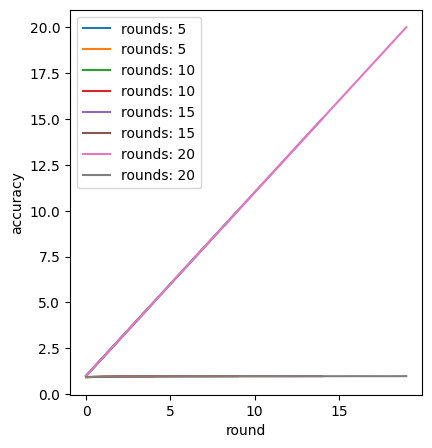

In [58]:
num_rounds = [5,10,15,20]

accuracies = [histories[i].metrics_distributed['accuracy'] for i in range(len(histories))]

#plot one plot for each round number with the accuracy for each client
for i in range(len(num_rounds)):
    plt.figure(figsize=(10, 5))
    plt.plot(accuracies[i], label="accuracy")
    plt.legend()
    plt.xlabel("client")
    plt.ylabel("accuracy")
    plt.title("Accuracy for each client in round " + str(num_rounds[i]))
    plt.show()


In [31]:
print(histories[0]['accuracy'])

TypeError: 'History' object is not subscriptable

In [8]:
#
for h in histories: 

    

AttributeError: 'list' object has no attribute 'shape'